# Data Wrangling with Python: Open Street Map (Pittsburgh)

OpenStreetMap is collaborative initiative to provide free and editable maps and one of the most prminent examples of [volunteered geographic information.](https://en.wikipedia.org/wiki/Volunteered_geographic_information). While very useful, OSM data can be quite messy at times. In this post, I will walk you through the cleaning the data, storing it in the CSV format and analyzing it via SQL queries. In this project I chose Pittsburgh as it is close to where I live and I have done lots of research on this city. You can find the link to the XML download [here.](https://www.openstreetmap.org/export#map=12/40.4313/-79.9805"). 

The process of data wrangling consists of the following steps: 

* Downloading the XML file
* Understanding the structure of OSM XMLs
* Auditing the types of tags and attributes
* Systematically checking for inconsistencies
* Editting the inconsistent values
* Saving the data in CSV format (not necessary but included here for instructional purposes)
* Converting the CSV format to SQL Database
* Analysing the data using SQL queries

**QUESTIONS** :At last, I will try to answer domw questions derived from this dataset: Which zipcodes have the highest number of contributions by the OSM users? which users have contributed more? What types of buildings can be found in Pittsburgh and how many of each can be found in each zipcode? 

First, we import all the required libraries: 

In [1]:
import xml.etree.cElementTree as ET
from collections import defaultdict
import re
import pprint
import codecs
import csv
import sqlite3
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
osm_file = "C:/Users/sur216/Box Sync/school stuff/Udacity/Data Analyst/p3_OSM/pittsburgh_pennsylvania.osm"
print "file {!r} is {!s} MB".format("pittsburgh_pennsylvania.osm",round(os.path.getsize("pittsburgh_pennsylvania.osm")/(1024*1024.0),1))
pittsburgh = open(osm_file,"r")

file 'pittsburgh_pennsylvania.osm' is 422.6 MB


Now we write a function to see what the unique tags are in this XML file. The following function shows all the unique tags found in our dataset and their frequency. After running the function, we can see that **osm** and **bounds** are root elements and other tags are child. 

In [4]:
def tag_count():
    pittsburgh = open(osm_file,"r")
    tags = {}
    for _,elem in ET.iterparse(pittsburgh):  
        if tags.get(elem.tag)== None: tags.update({elem.tag:1})
        else: tags[elem.tag] += 1
    return tags
tag_count()

{'bounds': 1,
 'member': 33397,
 'nd': 2292707,
 'node': 1983748,
 'osm': 1,
 'relation': 3107,
 'tag': 1315812,
 'way': 205378}

Taking a look at the OSM xml structure found [here](http://wiki.openstreetmap.org/wiki/OSM_XML) reveals a few helpful points about this xml file. first, all the information about Pittsburgh are stored in "node" and "way" tags. To check for consistency, we will first take a look at the key names for these tag attributes. The following function identifies all the unique attributes in these tags: 

In [5]:
def att():
    pittsburgh = open(osm_file,"r")
    k_way = {}
    k_node = {}
    for _,elem in ET.iterparse(pittsburgh, events = ("start",)):
        if elem.tag == "way":  
            for tag in elem.iter("tag"):
                if k_way.get(tag.attrib['k'])==None: k_way.update({tag.attrib['k']:1})
                else: k_way[tag.attrib['k']] +=1
        if elem.tag =="node": 
            for tag in elem.iter("tag"):
                if k_node.get(tag.attrib['k'])==None: k_node.update({tag.attrib['k']:1})
                else: k_node[tag.attrib['k']] +=1                    
    return (k_way, k_node)   

 As we can see there are a plenty of attrbutes available in this file. Cleaining all of them take a lot of time. Therefore, we will look into one of the frequent ones i.e. **"addr:street"**, **"building"**,and **"addr:postcode"**. This attrbute is supposed to be the street names and given its importance it should be consistent in the entire dataset. we will now define a function to audit the street names. To simplify the process, I will define multiple functions to use while looping through the XML. This function tell whether an element in the XML is the kind of attribute that we are interested in or not. 

In [6]:
def is_building(elem):
    return (elem.attrib['k'] == "building")

def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

def is_zipcode(elem):
    return (elem.attrib['k'] == "addr:postcode")

def is_city(elem):
    return (elem.attrib['k']== "addr:city")

def is_county(elem):
    return (elem.attrib['k']== "addr:county")

def is_state (elem):
    return (elem.attrib['k']== "addr:state")

def user (elem):
    return (elem.attrib['uid'])

We can easily check the extent of contribution for each user at this stage. Function below shows that Pittsburgh has 1313 users.

In [7]:
#this function returns the extent of contribution of each user as well as the number of users overall. 
def unique_users():
    pittsburgh = open(osm_file,"r")
    dct = {}
    for _,elem in ET.iterparse(pittsburgh, events = ("start",)):
            if elem.tag == "way" or elem.tag == "node" or elem.tag =="relation": 
                if dct.get(user(elem)) == None: dct.update({user(elem):1})
                else: dct[user(elem)]+=1
    return (len(dct.keys()),dct)
# 1313 users have contributed

To further discover the structure of this dataset. It's a good idea to find the unique values for different attributes found under "node" and "way" tags. 

In [8]:
#insert one of the following as function: "is_building","is_city","is_state","is_street_name",is_zipcode","is_county"
def unique_features(function):
    pittsburgh = open(osm_file,"r")
    dct = {}
    for _,elem in ET.iterparse(pittsburgh, events = ("start",)):
            if elem.tag == "way" or elem.tag == "node":  
                for tag in elem.iter("tag"):
                    if function(tag):
                        if dct.get(tag.attrib['v'])==None: dct.update({tag.attrib['v']:1})
                        else: dct[tag.attrib['v']]+=1
    return dct

In [10]:
unique_features(is_building)
unique_features(is_state)

{'15219': 1,
 'MD': 10,
 'OH': 44,
 'Ohio': 4,
 'P': 1,
 'PA': 3288,
 'Pa': 7,
 'WV': 33,
 'pa': 6}

We can see that some errors have occured by the users while entering data into OSM. The common abbreviation for "Pennsylvania"   is "PA" while we can see some other forms here(e.g. p,pa etc.). Some other abbreviations belong to other states which cannot possibly be correct. NOw let's take a look at the buildings: 

The main problem is that a good number of the users have inserted yes/no for this field assuming OSM wants to know whether a given object is building or not. There are a multitude of building types in this dataset and ofcourse many errors and inconsistencies. (e.g. we have both house and residential). We will now define a couple functions to audit the street names and zipcodes. it's important to know that Pittsburgh metropolitan area has 364 zipcodes ranging from **15001** to **16263** ([see here](http://www.bestplaces.net/find/zip.aspx?st=pa&msa=38300)).

In [20]:
expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 
            "Trail", "Parkway", "Commons", "Ring Road","Route","Alley","Circle","Terrace","Way","Highway"]
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)
street_types = defaultdict(set)
invalid_zipcodes = defaultdict(int)

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)

def audit_zipcode(invalid_zipcodes,zipcode):
    try:
        if not (15001 <= int(zipcode) <= 16263):
            raise ValueError
    except ValueError:
        invalid_zipcodes[zipcode] += 1

We will now define the **"audit()"** function to simultanioulsly check for errors in both zip codes and street names. 

In [27]:
def audit():
    pittsburgh = open(osm_file,"r")
    for _,elem in ET.iterparse(pittsburgh, events = ("start",)):
        if elem.tag == "way" or elem.tag == "node":  
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
                elif is_zipcode(tag):
                    audit_zipcode(invalid_zipcodes, tag.attrib['v'])
    return (invalid_zipcodes, street_types) 

In [28]:
audit()

(defaultdict(int,
             {'15010-4503': 4,
              '15147-1423': 2,
              '15203-2275': 2,
              '15206-3807': 2,
              '15206-4320': 2,
              '15206-4336': 2,
              '15206-4403': 4,
              '15206-4449': 2,
              '15206-4456': 2,
              '15206-4471': 2,
              '15206-4472': 2,
              '15206-4818': 2,
              '15210-1845': 2,
              '15212-5890': 2,
              '15213-1400': 2,
              '15213-1405': 4,
              '15213-1500': 2,
              '15213-1502': 6,
              '15213-1503': 2,
              '15213-1530': 2,
              '15213-1678': 2,
              '15213-1704': 2,
              '15213-1705': 2,
              '15213-1713': 2,
              '15213-1738': 2,
              '15213-1763': 2,
              '15213-2608': 2,
              '15213-2712': 2,
              '15213-2909': 4,
              '15213-2911': 4,
              '15213-3704': 2,
              '15213-

As you can see there are a large number of attributes and the data entered are not as accurate. The process of editing could be extended to all those attributes. For the purposes of this project we will try to edit zip codes, streets and state. Auditing the zip codes showed that some of the zipcodes are in 9-digits format while most of our zip codes are in 5-digits. Some zip codes also include "PA" at the beginning which is redundant. The street names also show a number of inconsistencies however, we can remedy most of these by creating a dictionary that converts the undesired abbreviations to a standard form. 

In [183]:
# standardize street names

mapping_str = {"Av": "Avenue","Av.":"Avenue","Ave":"Avenue","Ave.":"Avenue","Blvd":"Boulevard",
               "Dr":"Drive","dr":"Drive","DR":"Drive","Dr.":"Drive","Hwy":"Highway","Ln":"Lane",
               "Pl":"Place","Rd":"Road","ST":"Street","St":"Street","Sq":"Square","St.":"Street",
               "Ter":"Terrace","Ct":"Court","CT":"Court","center":"Center"}
               
def update_street_name(name, mapping_str):
    name = name.split(' ')
    type = name[-1]
    if type in mapping_str:
        name[-1] = mapping_str[type]
    
    name = ' '.join(name)
    name = name.title()

    return name

In case of zip codes, we delete those that are not within [15001,16263] range and get rid of the text characters as well. If the zip code is not within that range or is not a number at all the function returns "NA". We will also change the 9-digit format to 5 digits.

In [181]:
#standardize zipcodes
def update_zipcode(zipcode):
    lst = [int(s) for s in re.findall(r'\d+', zipcode)]
    if lst == []: new_zipcode = "0"
    else: 
        new_zipcode = lst[0]
        if not 15001 <= int(new_zipcode) <= 16263: new_zipcode = "0"
    return new_zipcode

Since I am goinng to answer some questions about the building type later on, It would be a better idea to simplify the buildings types and categorize them into a few well-known groups. The following function converts the building types to one of the following : **residential, commercial, education, industrial, aggriculture, parking, service and other**. 

In [408]:
#standardize landuse types
mapping_bld = {'chapel':'church','condominium':'residential','dormitory':'residential',
               'garage':'parking','garages':'parking','store':'commercial',
               'house':'residential','motel':'commercial','hotel':'commercial','restaurant':'commercial',
               'shopping_center':'commercial','retail':'commercial','kindergarten':'education',
               'school':'education','college':'education', 'university':'education','warehouse':'industrial',
               'silo':'industrial','storage_tank':'industrial','manufacture':'industrial','supermarket':'commercial',
               'pumping_station':'commercial','greenhouse':'agriculture', 'farm':'agriculture','train_station':'service',
               'Middle_School':'education','athletic_club':'commercial','hospital':'service','apartments':'residential'}

def update_landuse(building):
    if not mapping_bld.get(building)==None:building = mapping_bld[building]
    else : building = "other"
    return building 

# Modify and save the attributes into a CSV file

For instructional purposes I will convert the XML file to CSV file as this is one of the most common practices. Working with CSV format is much easier and it is important to know how to convert XML to CSV. Below, I will convert the XML to 4 separate CSV tables: **ways,nodes,ways_tags,nodes_tags** the first two hold information on the users, edit timestamp and version as well as latitude and longitude in case of nodes. The second two, hold teh attributed for the first two. ways and ways_tags ahve a common field named "way_id" and "node_id" for nodes and nodes_tags cases. The process is as follows: first, make dictionaries of the desired tags and attributes, convert them to Pandas Dataframes, and at last, save them as CSV files. 

In [230]:
# create nodes table
node_cols = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
def nodes_table ():
    pittsburgh = open(osm_file,"r")
    nodes = defaultdict(list)
    for _,elem in ET.iterparse(pittsburgh, events = ("start",)):
        if elem.tag == "node":
            for col in node_cols:
                try:    
                    nodes[col].append(elem.attrib[col].encode('utf-8'))
                except:
                    nodes[col].append(float('nan'))
    return pd.DataFrame(nodes).fillna(method='ffill')
nodes_table().to_csv('nodes.csv', index=True, header=False)
nodes = nodes_table()
nodes.head(10)

,changeset,id,lat,lon,timestamp,uid,user,version
0,134337,31479671,40.1688251,-80.10257,2007-07-09T03:10:11Z,867,tscofield,1
1,9571084,31479864,40.2235788,-79.6058815,2011-10-16T11:03:11Z,252811,rickmastfan67,3
2,9571084,31479865,40.222309,-79.6047754,2011-10-16T11:03:11Z,252811,rickmastfan67,2
3,9571084,31479867,40.2195687,-79.6026969,2011-10-16T11:03:11Z,252811,rickmastfan67,3
4,9571084,31479868,40.2187497,-79.6018514,2011-10-16T11:03:11Z,252811,rickmastfan67,4
5,1878278,31479869,40.2180308,-79.6006994,2009-07-19T21:23:57Z,4115,Andy Allan,2
6,1878278,31479870,40.2173885,-79.5991201,2009-07-19T21:37:40Z,4115,Andy Allan,3
7,1878278,31479871,40.2169298,-79.5979528,2009-07-19T21:39:28Z,4115,Andy Allan,4
8,134337,31479872,40.2164528,-79.5968732,2007-07-09T03:20:49Z,867,tscofield,1
9,1878278,31479873,40.2159794,-79.5962791,2009-07-19T21:38:29Z,4115,Andy Allan,2


In [277]:
#creat ways table
way_cols = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
def ways_table():
    pittsburgh = open(osm_file,"r")
    ways= defaultdict(list)
    for _, elem in ET.iterparse(pittsburgh, events=("start",)):
        if elem.tag == "way":
            for col in way_cols:
                try:
                    ways[col].append(elem.attrib[col].encode('utf-8'))
                except:
                    ways[col].append(float('nan'))
    return pd.DataFrame(ways).fillna(method='ffill')
ways_table().to_csv('ways.csv', index=True, header=False)
ways = ways_table()
ways.head(10)

,changeset,id,timestamp,uid,user,version
0,9927059,4943701,2011-11-23T22:41:59Z,207745,NE2,10
1,39520649,5053988,2016-05-23T22:17:35Z,1961753,abbafei,24
2,39520649,5054023,2016-05-23T22:14:34Z,1961753,abbafei,27
3,34439012,5068379,2015-10-05T00:02:32Z,613256,MCollar,11
4,10111415,9650873,2011-12-13T21:42:07Z,334153,Alexander Roalter,13
5,14363227,11643734,2012-12-22T08:29:52Z,451693,bot-mode,2
6,14363227,11643753,2012-12-22T08:29:52Z,451693,bot-mode,2
7,14461551,11643754,2012-12-30T10:22:59Z,451693,bot-mode,2
8,15784263,11643782,2013-04-19T11:49:48Z,451693,bot-mode,2
9,36309906,11644056,2016-01-02T02:05:35Z,2835510,GeoKitten,7


The nodes_tags and ways_tags are a bit more complicated. Here, we want to edit the data by means of the functions that we defined earlier (e.g. update_landuse, update_street_name etc.). Additionally, as we saw earlier, some attributed have a colon character in them (e.g. addr:street). We want to know th type of these attributes (e.g. addr, tiger etc.) therefore, we will check if a colon character exists first, if the colon exists we split on ":" and save the left side of teh split in another column. if no colon exists then "NA" will be applied to that column. 

In [273]:
#create nodes_tags table
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')
#nodes_tags_cols = ['id','attribute', 'value', 'attribute_type']
def nodes_tags_table ():
    pittsburgh = open(osm_file,"r")
    nodes_tags = defaultdict(list)
    for _,elem in ET.iterparse(pittsburgh, events = ("start",)):
        if elem.tag == "node":
            for tag in elem.iter("tag"):
                if not problemchars.search(tag.attrib['k']):
                    nodes_tags['id'].append(elem.attrib['id'])
                    cln = lower_colon.search(tag.attrib['k'])
                    # if colon exists in the 'k' attribute
                    if cln: 
                        nodes_tags['attribute'].append(tag.attrib['k'].split(":",1)[1])
                        nodes_tags['attribute_type'].append(tag.attrib['k'].split(":",1)[0])
                    # if colon does not exist in 'k' attribute
                    else: 
                        nodes_tags['attribute'].append(tag.attrib['k'])
                        nodes_tags['type'].append('NA')
                    # modify some values (i.e. street names, buildings, and zipcodes)
                    if is_zipcode(tag):nodes_tags['value'].append(update_zipcode(tag.attrib['v']))
                    elif is_street_name(tag):nodes_tags['value'].append(update_street_name(tag.attrib['v'], mapping_str))
                    elif is_building(tag): nodes_tags['value'].append(update_landuse(tag.attrib['v']))
                    else: nodes_tags['value'].append(tag.attrib['v'].encode('utf-8'))
    return pd.DataFrame(dict([(x,pd.Series(y)) for x,y in nodes_tags.iteritems()]))
nodes_tags_table().to_csv('nodes_tags.csv', index=True, header=False)
nodes_tags = nodes_tags_table()
nodes_tags.head(10)

,attribute,attribute_type,id,type,value
0,created_by,is_in,31479671,NA,JOSM
1,created_by,is_in,31479872,NA,JOSM
2,created_by,name,31479874,NA,JOSM
3,created_by,name,31479879,NA,JOSM
4,created_by,name,31479883,NA,JOSM
5,created_by,gnis,31479887,NA,JOSM
6,created_by,odbl,31479888,NA,JOSM
7,created_by,odbl,31479890,NA,JOSM
8,created_by,odbl,31479892,NA,JOSM
9,created_by,odbl,31479936,NA,JOSM


In [416]:
def ways_tags_table ():
    pittsburgh = open(osm_file,"rb")
    ways_tags = defaultdict(list)
    for _,elem in ET.iterparse(pittsburgh, events = ("start",)):
        if elem.tag == "way":
            for tag in elem.iter("tag"):
                if not problemchars.search(tag.attrib['k']):
                    ways_tags['id'].append(elem.attrib['id'])
                    cln = lower_colon.search(tag.attrib['k'])
                    # if colon exists in the 'k' attribute
                    if cln: 
                        ways_tags['attribute'].append(tag.attrib['k'].split(":",1)[1])
                        ways_tags['attribute_type'].append(tag.attrib['k'].split(":",1)[0])
                    # if colon does not exist in 'k' attribute
                    else: 
                        ways_tags['attribute'].append(tag.attrib['k'])
                        ways_tags['type'].append('NA')
                    if is_zipcode(tag):ways_tags['value'].append(update_zipcode(tag.attrib['v']))
                    elif is_street_name(tag):ways_tags['value'].append(update_street_name(tag.attrib['v'], mapping_str))
                    elif is_building(tag): ways_tags['value'].append(update_landuse(tag.attrib['v']))
                    else: ways_tags['value'].append(tag.attrib['v'].encode('utf-8'))
    return pd.DataFrame(dict([(x,pd.Series(y)) for x,y in ways_tags.iteritems()])) 
ways_tags_table().to_csv('ways_tags.csv', index=True, header=False)
ways_tags = ways_tags_table()
ways_tags.head(10)

,attribute,attribute_type,id,type,value
0,hgv,tiger,4943701,NA,designated
1,ref,tiger,4943701,NA,I 79
2,foot,tiger,4943701,NA,no
3,horse,tiger,4943701,NA,no
4,lanes,tiger,4943701,NA,2
5,oneway,tiger,4943701,NA,yes
6,bicycle,tiger,4943701,NA,no
7,highway,tiger,4943701,NA,motorway
8,maxspeed,tiger,4943701,NA,55 mph
9,sidewalk,tiger,4943701,NA,none


# Converting the CSV to DB Using SQL

In this section, I will convert the CSV format to SQL database and run a few queries to extract some information and answer some questions that I posed at the beginning. There are multiple ways of doing this, the way that I chose was to first create a table (or schema) with desired data taypes and then loop through every row of the previously saved CSV files, convert the columns data type to the types determined in the schema and insert them into the database. I chose to re-open the CSV file again for instructional purposes as loading a CSV file into a database is a quite common practice. 

In [582]:
#create sql table for nodes
con = sqlite3.connect('osm.db')
con.text_factory = str
cur = con.cursor()
cur.execute('''CREATE TABLE nodes (
    id  INTEGER PRIMARY KEY NOT NULL,
    changeset INTEGER,
    node_id INTEGER,
    lat FLOAT,
    lon FLOAT,
    timestamp TIMESTAMP,
    user_id INTEGER,
    user TEXT,
    version INTEGER);''') 

with open ('nodes.csv', 'rb') as table:
    reader = csv.reader(table)
    dicts =({'id': int(line[0]), 'changeset': int(line[1]), 'node_id':int(line[2]), 'lat':float(line[3]),'lon':float(line[4]),
             'timestamp':line[5], 'user_id':int(line[6]),'user':line[7],'version':int(line[8])} for line in reader) 
    to_db = ((i['id'], i['changeset'],i['node_id'],i['lat'],i['lon'],i['timestamp'],i['user_id'],i['user'],i['version']) for i in dicts)  
    cur.executemany("INSERT INTO nodes (id, changeset,node_id,lat,lon,timestamp,user_id,user,version) VALUES (?,?,?,?,?,?,?,?,?);", to_db)
con.commit()

In [583]:
# column names and data types in nodes table
quer("PRAGMA table_info(nodes)")

[(0, 'id', 'INTEGER', 1, None, 1),
 (1, 'changeset', 'INTEGER', 0, None, 0),
 (2, 'node_id', 'INTEGER', 0, None, 0),
 (3, 'lat', 'FLOAT', 0, None, 0),
 (4, 'lon', 'FLOAT', 0, None, 0),
 (5, 'timestamp', 'TIMESTAMP', 0, None, 0),
 (6, 'user_id', 'INTEGER', 0, None, 0),
 (7, 'user', 'TEXT', 0, None, 0),
 (8, 'version', 'INTEGER', 0, None, 0)]

In [576]:
#create sql table for ways
cur.execute('''CREATE TABLE ways (
    id  INTEGER PRIMARY KEY NOT NULL,
    changeset INTEGER,
    way_id INTEGER,
    timestamp TIMESTAMP,
    user_id INTEGER,
    user TEXT,
    version INTEGER);''') 

with open ('ways.csv', 'rb') as table:
    reader = csv.reader(table)
    dicts =({'id': int(line[0]), 'changeset': int(line[1]), 'way_id':int(line[2]),
             'timestamp':line[3], 'user_id':int(line[4]),'user':line[5],'version':int(line[6])} for line in reader) 
    to_db = ((i['id'], i['changeset'],i['way_id'],i['timestamp'],i['user_id'],i['user'],i['version']) for i in dicts)  
    cur.executemany("INSERT INTO ways (id, changeset,way_id,timestamp,user_id,user,version) VALUES (?,?,?,?,?,?,?);", to_db)
con.commit()

In [577]:
# column names and data types in ways table
quer("PRAGMA table_info(ways)")

[(0, 'id', 'INTEGER', 1, None, 1),
 (1, 'changeset', 'INTEGER', 0, None, 0),
 (2, 'way_id', 'INTEGER', 0, None, 0),
 (3, 'timestamp', 'TIMESTAMP', 0, None, 0),
 (4, 'user_id', 'INTEGER', 0, None, 0),
 (5, 'user', 'TEXT', 0, None, 0),
 (6, 'version', 'INTEGER', 0, None, 0)]

In [578]:
#create sql table for nodes_tags
cur.execute('''CREATE TABLE nodes_tags (
    id  INTEGER PRIMARY KEY NOT NULL,
    attribute TEXT,
    attribute_type TEXT,
    node_id INTEGER,
    data_type TEXT,
    value TEXT);''') 

with open ('nodes_tags.csv', 'rb') as table:
    reader = csv.reader(table)
    dicts =({'id': int(line[0]), 'attribute': line[1],'attribute_type': line[2], 'node_id':int(line[3]), 'data_type':line[4],
             'value':line[5]} for line in reader) 
    to_db = ((i['id'], i['attribute'],i['attribute_type'],i['node_id'],i['data_type'],i['value']) for i in dicts)  
    cur.executemany("INSERT INTO nodes_tags(id, attribute,attribute_type,node_id,data_type,value) VALUES (?,?,?,?,?,?);", to_db)
con.commit()
# column names and data types in nodes_tags table
quer("PRAGMA table_info(nodes_tags)")

[(0, 'id', 'INTEGER', 1, None, 1),
 (1, 'attribute', 'TEXT', 0, None, 0),
 (2, 'attribute_type', 'TEXT', 0, None, 0),
 (3, 'node_id', 'INTEGER', 0, None, 0),
 (4, 'data_type', 'TEXT', 0, None, 0),
 (5, 'value', 'TEXT', 0, None, 0)]

In [579]:
#create sql table for ways_tags
cur.execute('''CREATE TABLE ways_tags (
    id  INTEGER PRIMARY KEY NOT NULL,
    attribute TEXT,
    attribute_type TEXT,
    way_id INTEGER,
    data_type TEXT,
    value TEXT);''') 

with open ('ways_tags.csv', 'rb') as table:
    reader = csv.reader(table)
    dicts =({'id': int(line[0]), 'attribute': line[1],'attribute_type': line[2], 'way_id':int(line[3]), 'data_type':line[4],
             'value':line[5]} for line in reader) 
    to_db = ((i['id'], i['attribute'],i['attribute_type'],i['way_id'],i['data_type'],i['value']) for i in dicts)  
    cur.executemany("INSERT INTO ways_tags(id, attribute,attribute_type,way_id,data_type,value) VALUES (?,?,?,?,?,?);", to_db)
con.commit()
# column names and data types in ways_tags table
quer("PRAGMA table_info(ways_tags)")

[(0, 'id', 'INTEGER', 1, None, 1),
 (1, 'attribute', 'TEXT', 0, None, 0),
 (2, 'attribute_type', 'TEXT', 0, None, 0),
 (3, 'way_id', 'INTEGER', 0, None, 0),
 (4, 'data_type', 'TEXT', 0, None, 0),
 (5, 'value', 'TEXT', 0, None, 0)]

**FILE SIZES**: we now define a function to loop through all our files that we have created so far and report their sizes. The original OSM file is the largest and the size has shrinked after making our databases. Mostly because we didn't include all the tags. The largest CSV file is the "nodes.csv". 

* file 'nodes.csv' is 172.6 MB
* file 'ways.csv' is 13.0 MB
* file 'nodes_tags.csv' is 11.0 MB
* file 'ways_tags.csv' is 37.7 MB
* file 'osm.db' is 365.5 MB
* file 'pittsburgh_pennsylvania.osm' is 422.6 MB

In [604]:
files_lst = ['nodes.csv','ways.csv','nodes_tags.csv','ways_tags.csv','osm.db', 'pittsburgh_pennsylvania.osm']
for i in files_lst: 
    print ("file {!r} is {!s} MB".format(i,round(os.path.getsize(i)/(1024*1024.0),1)))

# Analyzing the Data Using SQL

In this section I will try to answer some questions via SQL queries. First we define a couple functions to simplify the querying and plotting process:

In [559]:
# we generated the following tables: ways,ways_tags,nodes,nodes_tags
con = sqlite3.connect('osm.db')
con.text_factory = str
cur = con.cursor()
def quer(a):
    return cur.execute(a).fetchall()

def barplot_quer (m,a,b):
    %matplotlib inline
    y = [int(i[a]) for i in m]
    labels = [i[b] for i in m]
    x = range(1,len(y)+1)
    plt.bar(x, y, align = "center")
    plt.xticks(x, labels, rotation='vertical')
    
    

# which users have contributed most to OSM in Pittsburgh? 

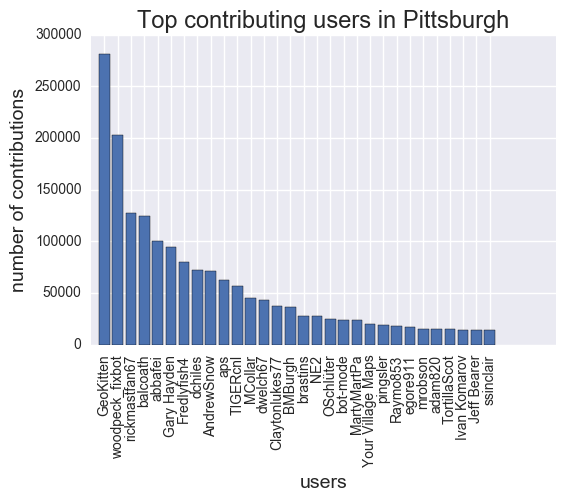

In [560]:
# top 30 contributing users
m = quer('''SELECT user,user_id,count(*) FROM   
     (SELECT user_id,user FROM nodes
      UNION ALL
      SELECT user_id,user FROM ways)    
     nodes group by user_id order by count(*) Desc limit 30;''')
barplot_quer (m,2,0)
plt.xlabel('users', fontsize=14)
plt.ylabel('number of contributions', fontsize=14)
plt.title('Top contributing users in Pittsburgh', fontsize=17)

# Which zipcodes have the highest number of data entery by users? 

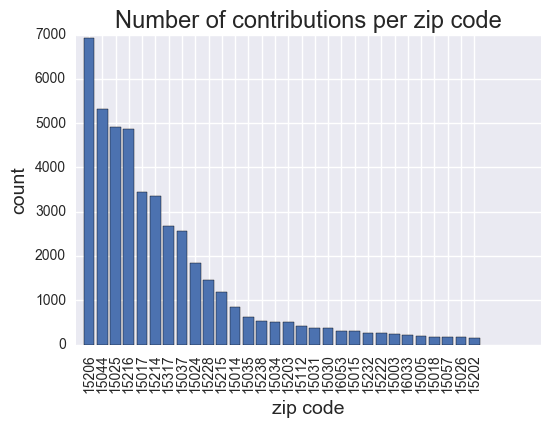

In [561]:
m = quer('''SELECT value,count(*) FROM 
         (SELECT * FROM ways_tags
         UNION ALL
         SELECT * FROM nodes_tags)
         where attribute ='postcode' group by value order by count(*) Desc limit 30;''')
barplot_quer (m,1,0)
plt.xlabel('zip code', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.title('Number of contributions per zip code', fontsize=17)

# what types of attrbutes can be found in the Pittsburgh OSM file (e.e. address, tiger data etc.)

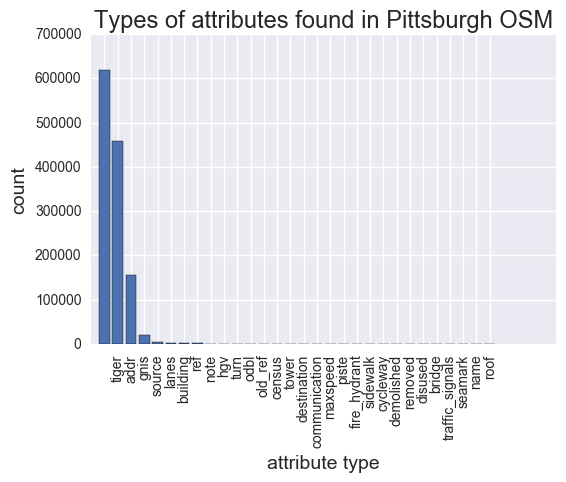

In [562]:
m = quer('''SELECT attribute_type,count(*) FROM 
         (SELECT attribute_type FROM ways_tags
         UNION ALL
         SELECT attribute_type FROM nodes_tags)
         group by attribute_type order by count(*) Desc limit 30;''')
barplot_quer (m,1,0)
plt.xlabel('attribute type', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.title('Types of attributes found in Pittsburgh OSM', fontsize=17)
# the first column is for the NA values, that is no colon were found in these attrbutes

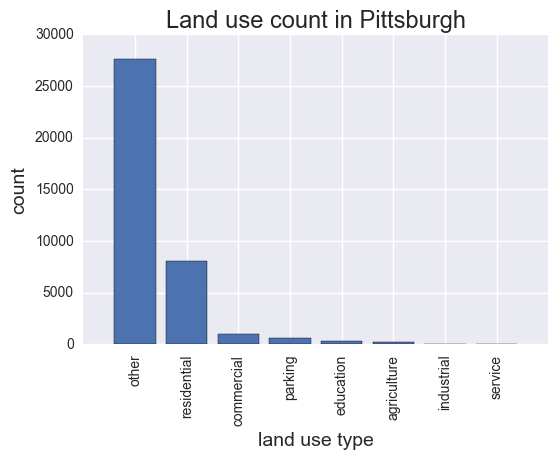

In [563]:
m = quer("SELECT value,count(*) FROM ways_tags where attribute ='building' group by value order by count(*) Desc limit 8;")
barplot_quer (m,1,0)
plt.xlabel('land use type', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.title('Land use count in Pittsburgh', fontsize=17)

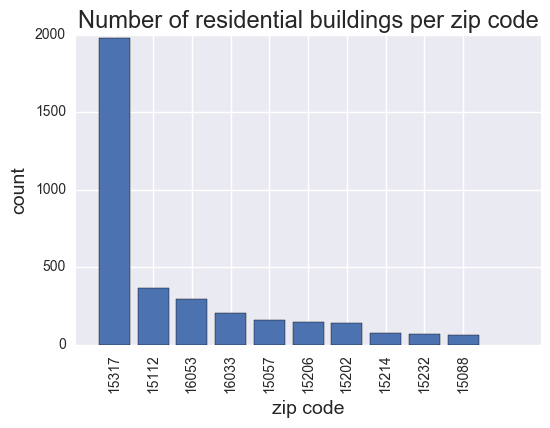

In [567]:
quer("CREATE TABLE zipcodes AS SELECT * FROM ways_tags WHERE attribute ='postcode';")
quer("CREATE TABLE buildings AS SELECT * FROM ways_tags WHERE attribute ='building';")

m = quer('''SELECT zipcodes.value,buildings.value, count(buildings.value) 
            as count FROM buildings join zipcodes on buildings.way_id = zipcodes.way_id 
            WHERE buildings.value == 'residential' group by zipcodes.value order by count(buildings.value) Desc limit 10;''')
barplot_quer (m,2,0)
plt.xlabel('zip code', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.title('Number of residential buildings per zip code', fontsize=17)

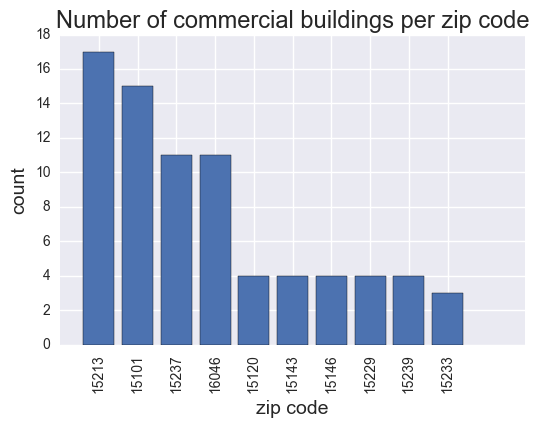

In [568]:
m = quer('''SELECT zipcodes.value,buildings.value, count(buildings.value) 
            as count FROM buildings join zipcodes on buildings.way_id = zipcodes.way_id 
            WHERE buildings.value == 'commercial' group by zipcodes.value order by count(buildings.value) Desc limit 10;''')
barplot_quer (m,2,0)
plt.xlabel('zip code', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.title('Number of commercial buildings per zip code', fontsize=17)

# Conclusion and Other Ideas


My analysis indicated that the distribution of OSM contributions are not consistent accross different zipcodes. This could be due to the low number of contributers (u.e. 1313) in Pittsburgh. Another limitation was lack of appropriate standard format for different types of data. As we saw in building types attributes, there were a lot of confusion as what OSM wants from the user to enter. 

My methodology can be applied to any other city and the process would be more or less the same. The only part that might require some changes would be the mapping dictionaries for altering the formattings. This issue is context sensitive and is rather arbitrary. =The major advantage of OSM in my opinion is that the software automatically enters some data that are not exposed to human errors. User_id, and latitude and longitude are some of these useful informattion. One can use these data to see which areas of the city are most discovered, where people go and how integrated are different neighborhoods in the city.